In [1]:
# Explore

In [143]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import time

from lime import lime_image
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas

import input_data
import models

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [237]:

tf.reset_default_graph()

def setup(sample_rate=16000, clip_duration_ms=1000.0,
            window_size_ms=30.0, window_stride_ms=10.0,
            feature_bin_count=40, preprocess='logmel', n_classes=12,
            silence = 10.0, unknown = 10.0,
            testing = 10.0, validation = 10.0):

    m = models.prepare_model_settings(n_classes, sample_rate,
                                      clip_duration_ms, window_size_ms, window_stride_ms,
                                      feature_bin_count, preprocess)
    
    wanted_words = 'yes,no,up,down,left,right,on,off,stop,go'.split(',')
    p = input_data.AudioProcessor(None, '../../data/speech_dataset/',
                                silence, unknown, wanted_words,
                                validation, testing, m, None)
    p.wanted_words = wanted_words
    return m, p

model_settings, audio_processor = setup(feature_bin_count=32)


def wav_to_features(input_wav):
    results = audio_processor.get_features_for_wav(input_wav, model_settings, session)
    features = results[0]
    return features

#f = wav_to_features('../../data/speech_dataset/nine/122c5aa7_nohash_0.wav')
#f.shape

ff 32 98


In [238]:
image_size = (98, model_settings['fingerprint_width'], 1)
f_size = (None, 98, model_settings['fingerprint_width'], 1)

processed_images = tf.placeholder(tf.float32, shape=f_size)
model = models.create_model(processed_images, model_settings,
                            model_architecture='low_latency_conv', is_training=False)

session = tf.Session()

def transform_img_fn(path_list):
    out = []
    for f in path_list:
        image = wav_to_features(f).squeeze()
        s = (image.shape[0], image.shape[1], 3)
        fake_rgb = np.ndarray(shape=s, dtype=image.dtype)
        fake_rgb[:,:, 0] = image
        fake_rgb[:,:, 1] = 0
        fake_rgb[:,:, 2] = 0
        i = tf.convert_to_tensor(fake_rgb) 
        out.append(i)
    return session.run([out])[0]

#tf.get_variable_scope().reuse_variables()

checkpoint = '../../data/speech-logmel32/low_latency_conv.ckpt-26000'

models.load_variables_from_checkpoint(session, checkpoint)
saver = tf.train.Saver(tf.global_variables())
saver.restore(session, checkpoint)

probabilities = model
def predict_fn(images):
    images = [ np.expand_dims(img[:,:,0], axis=-1) for img in images ]
    return session.run(probabilities, feed_dict={processed_images: images})


p = predict_fn(transform_img_fn(['../../data/speech_dataset/left/122c5aa7_nohash_0.wav']))


conv out 25 1 186
---------
Variables: name (type shape) [size]
---------
first_weights:0 (float32_ref 98x8x1x186) [145824, bytes: 583296]
first_bias:0 (float32_ref 186) [186, bytes: 744]
first_fc_weights:0 (float32_ref 4650x128) [595200, bytes: 2380800]
first_fc_bias:0 (float32_ref 128) [128, bytes: 512]
second_fc_weights:0 (float32_ref 128x128) [16384, bytes: 65536]
second_fc_bias:0 (float32_ref 128) [128, bytes: 512]
final_fc_weights:0 (float32_ref 128x12) [1536, bytes: 6144]
final_fc_bias:0 (float32_ref 12) [12, bytes: 48]
Total size of variables: 759398
Total bytes of variables: 3037592
INFO:tensorflow:Restoring parameters from ../../data/speech-logmel32/low_latency_conv.ckpt-26000
INFO:tensorflow:Restoring parameters from ../../data/speech-logmel32/low_latency_conv.ckpt-26000


s (98, 32) (98, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


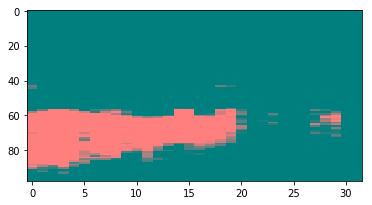

In [246]:

def explain(filepath, expected_label, ax=None):
    images = transform_img_fn([filepath])
    p = predict_fn(images)
    image = images[0]

    predicted = np.argmax(p[0])
    score = p[0][predicted]
    label = audio_processor.words_list[predicted]
    
    explainer = lime_image.LimeImageExplainer()
    start_time = time.time()
    
    explanation = explainer.explain_instance(image, predict_fn, top_labels=5, hide_color=0, num_samples=1000)
    explanation_time = time.time() - start_time
    
    from skimage.segmentation import mark_boundaries
    
    # TODO: plot frequency and time on axis
    temp, mask = explanation.get_image_and_mask(predicted, positive_only=True, num_features=10, hide_rest=True)
    
    if not ax:
        fig = plt.figure(figsize=(6,20))
        ax = fig.add_subplot(1, 1, 1)
    ax.imshow(mark_boundaries(temp / 2 + 0.5, mask), aspect=1/6)
    
explain('../../data/speech_dataset/down/122c5aa7_nohash_1.wav', 'down')
    

In [197]:
# return Pandas.DataFrame
def get_samples(audio_processor):
    
    data = {
        'split': [],
        'file': [],
        'label': [],
        'included': [],
    }
    
    for dataset, files in audio_processor.data_index.items():
        for sample in files:
            label = sample['label']
            data['included'].append(label in audio_processor.wanted_words)
            data['split'].append(dataset)
            data['label'].append(label)
            data['file'].append(sample['file'])
                  
    return pandas.DataFrame(data)

all_samples = get_samples(audio_processor)
samples = all_samples[all_samples.included == True]
print('labels', samples.label.unique(), len(samples.label.unique()))
samples.head(3)

labels ['go' 'up' 'no' 'down' 'yes' 'stop' 'off' 'right' 'left' 'on'] 10


,split,file,label,included
2,validation,../../data/speech_dataset/go/099d52ad_nohash_2...,go,True
4,validation,../../data/speech_dataset/up/026290a7_nohash_0...,up,True
5,validation,../../data/speech_dataset/no/c2d15ea5_nohash_0...,no,True


go


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

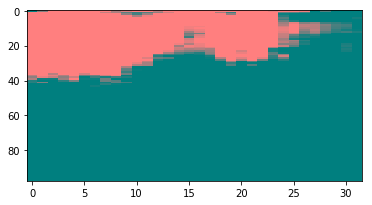

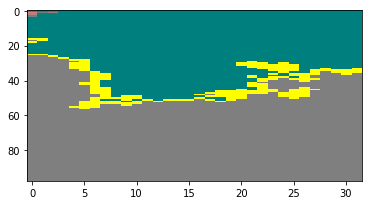

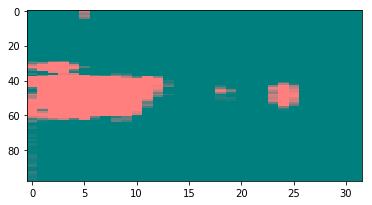

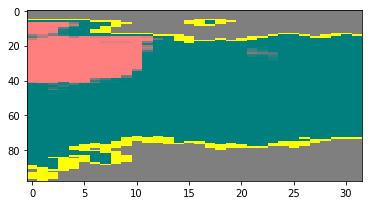

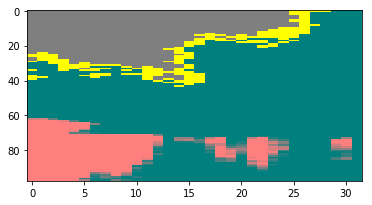

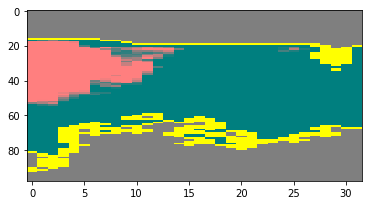

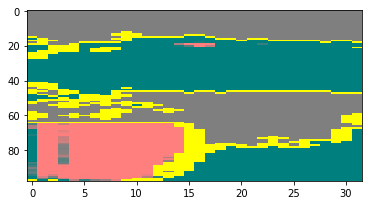

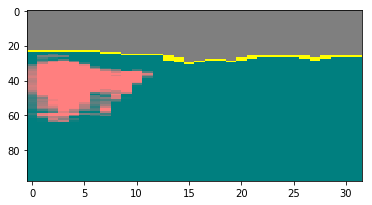

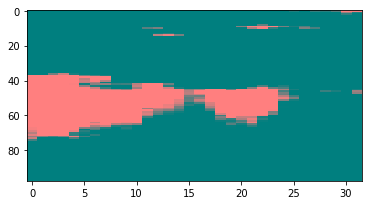

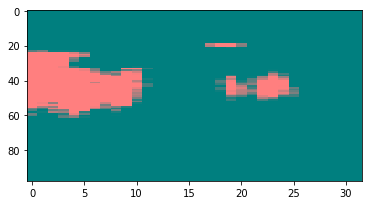

In [247]:
for label in samples.label.unique()[:1]:
    print(label)
    test = samples[samples.label == label].sample(10)
    for t in test.iterrows():
        _, data = t
        explain(data.file, data.label)